In [29]:
# @title Step 1: Install Dependencies
!pip install sentence-transformers faiss-cpu networkx pyyaml pandas numpy scikit-learn matplotlib seaborn ipywidgets -q

In [30]:
# @title Step 2: Imports & Configuration Setup
import os
import yaml
import pandas as pd
import numpy as np
import torch
import faiss
import networkx as nx
import re
import pickle
from sentence_transformers import SentenceTransformer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# Define the default configuration (Taxonomy)
DEFAULT_CONFIG = """
categories:
  - name: "Food & Dining"
    description: "Restaurants, fast food, food delivery apps, cafes, and dining out."
    keywords: ["swiggy", "zomato", "starbucks", "mcdonalds", "saravana bhavan", "chai point"]
  - name: "Groceries"
    description: "Supermarkets, vegetable markets, quick commerce, and daily essentials."
    keywords: ["blinkit", "zepto", "bigbasket", "dmart", "reliance fresh", "kirana", "general store"]
  - name: "Utilities"
    description: "Electricity, water, gas, mobile recharge, broadband, and dth bills."
    keywords: ["bescom", "tneb", "jio", "airtel", "vodafone", "act fiber", "mahavitaran"]
  - name: "Transportation"
    description: "Fuel, cabs, rideshare, trains, flights, and public transport."
    keywords: ["uber", "ola", "irctc", "indigo", "shell", "hpcl", "metro"]
  - name: "Shopping"
    description: "E-commerce, clothing, electronics, and general merchandise."
    keywords: ["amazon", "flipkart", "myntra", "ajio", "croma", "decathlon"]
  - name: "Entertainment"
    description: "Movies, streaming services, events, and games."
    keywords: ["bookmyshow", "pvr", "inox", "netflix", "hotstar"]
"""

def load_or_create_config(path='config.yaml'):
    if not os.path.exists(path):
        print(f"Config file not found. Creating default '{path}'...")
        with open(path, 'w') as f:
            data = yaml.safe_load(DEFAULT_CONFIG)
            yaml.dump(data, f, default_flow_style=False)

    with open(path, 'r') as f:
        print(f"Loading configuration from '{path}'...")
        return yaml.safe_load(f)

In [31]:
# @title Step 3: Define Persistent Neuro-Symbolic System
class IntelligentFinancialSystem:
    def __init__(self, config_path='config.yaml', model_name='all-mpnet-base-v2', graph_path='graph.pkl'):
        self.config_path = config_path
        self.graph_path = graph_path
        self.config = load_or_create_config(self.config_path)
        self._initialize_rules_and_categories()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Device: {self.device} | Model: {model_name}")
        self.model = SentenceTransformer(model_name, device=self.device)
        self._build_vector_index()
        self._load_graph_state()
        self.check_bias_coverage()

    def _initialize_rules_and_categories(self):
        self.rules = {}
        self.category_names = []
        for cat in self.config['categories']:
            self.category_names.append(cat['name'])
            self.rules[cat['name']] = [k.lower() for k in cat.get('keywords', [])]

    # Check for Bias in the dataset for unbiased AI
    def check_bias_coverage(self):
        regional_indicators = ['kirana', 'bhavan', 'store', 'general', 'tneb', 'bescom']
        all_keywords = [k for cat in self.rules.values() for k in cat]
        hits = [k for k in all_keywords if any(ind in k for ind in regional_indicators)]
        print("\nEthical AI Bias Audit")
        if hits:
            print(f"PASS: Regional/Generic diversity detected ({len(hits)} terms found).")
        else:
            print("WARNING: Taxonomy may be biased towards premium brands.")
        print("-----------------------------------\n")

    def _build_vector_index(self):
        descriptions = [f"{c['name']}: {c['description']}" for c in self.config['categories']]
        embeddings = self.model.encode(descriptions)
        faiss.normalize_L2(embeddings)
        self.index = faiss.IndexFlatIP(embeddings.shape[1])
        self.index.add(embeddings)

    def _load_graph_state(self):
        if os.path.exists(self.graph_path):
            print(f"Loading graph state from '{self.graph_path}'...")
            try:
                with open(self.graph_path, 'rb') as f:
                    self.graph = pickle.load(f)
            except Exception as e:
                print(f"Error loading graph: {e}. Starting fresh.")
                self.graph = nx.Graph()
        else:
            print("No existing graph state found. Initializing empty graph.")
            self.graph = nx.Graph()

    def save_state(self):
        # Save Config
        print(f"Saving configuration to '{self.config_path}'...")
        with open(self.config_path, 'w') as f:
            yaml.dump(self.config, f, default_flow_style=False)

        # Save Graph
        print(f"Saving graph state to '{self.graph_path}'...")
        with open(self.graph_path, 'wb') as f:
            pickle.dump(self.graph, f)

    def train_graph_context(self, historical_data):
        print(f"Building Graph Context from {len(historical_data)} past transactions...")
        for _, row in historical_data.iterrows():
            self._update_graph_node(row['transaction'], row['true_category'])
        self.save_state()

    def _update_graph_node(self, transaction_text, category):
        token = self._extract_merchant_token(transaction_text)
        if not self.graph.has_node(token):
            self.graph.add_node(token, type='merchant', categories=[])
        self.graph.nodes[token]['categories'].append(category)


    def _extract_merchant_token(self, text):
      text = text.upper().strip()
      text = re.sub(r'^(UPI|POS|ATM|ACH|IMPS|NEFT|RTGS|CRDT|DBT|TXN|REF|WDL)[-\s/]*', '', text)
      text = re.sub(r'[^A-Z0-9\s]', ' ', text).strip()

      text = re.sub(r'[\d]+', '', text)
      text = re.sub(r'\s+', ' ', text).strip()


      words = text.split()
      if words:
          token = max(words, key=len)
          return token

      return "UNKNOWN"

    def _get_graph_consensus(self, text):
        token = self._extract_merchant_token(text)
        if self.graph.has_node(token):
            cats = self.graph.nodes[token]['categories']
            if cats:
                most_common = Counter(cats).most_common(1)[0]
                confidence = most_common[1] / len(cats)
                return most_common[0], confidence, token
        return None, 0.0, token

    def predict(self, transaction_text):
        lower_text = transaction_text.lower()

        # 1. Symbolic Check (Rules)
        for cat, keywords in self.rules.items():
            for k in keywords:
                if k in lower_text:
                    return {"category": cat, "confidence": 1.0, "method": "Symbolic Rule", "reason": f"Matched keyword '{k}'"}

        # 2. Graph Context Check (Memory)
        graph_cat, graph_conf, token = self._get_graph_consensus(transaction_text)
        if graph_cat and graph_conf > 0.80:
            return {"category": graph_cat, "confidence": round(graph_conf, 2), "method": "Graph Context", "reason": f"History for '{token}'"}

        # 3. Neural Semantic Match (AI)
        embedding = self.model.encode([transaction_text])
        faiss.normalize_L2(embedding)
        D, I = self.index.search(embedding, 1)
        best_cat = self.category_names[I[0][0]]
        score = float(D[0][0])

        return {"category": best_cat, "confidence": round(score, 2), "method": "Neural Model", "reason": f"Semantic score: {score:.2f}"}

    def active_learning_update(self, transaction_text, correct_category):
        self._update_graph_node(transaction_text, correct_category)
        token = self._extract_merchant_token(transaction_text)

        if token.lower() not in [k.lower() for k in self.rules.get(correct_category, [])]:
            self.rules.setdefault(correct_category, []).append(token.lower())

        for cat_entry in self.config['categories']:
            if cat_entry['name'] == correct_category:
                if 'keywords' not in cat_entry:
                    cat_entry['keywords'] = []
                if token.lower() not in [k.lower() for k in cat_entry['keywords']]:
                    cat_entry['keywords'].append(token.lower())
                break

        self.save_state()
        return f"System Learned: '{token}' is now '{correct_category}' (Saved to Config & Graph)."

    def add_new_category(self, new_cat_name, description):
        if new_cat_name in self.category_names: return f"Category '{new_cat_name}' exists."
        self.config['categories'].append({'name': new_cat_name, 'description': description, 'keywords': []})
        self.category_names.append(new_cat_name)
        self.rules[new_cat_name] = []
        self._build_vector_index()
        self.save_state()
        return f"Added category: '{new_cat_name}'."


In [32]:
# @title Step 4: Data Gen & Evaluation Logic

def generate_robust_indian_data(n_samples=500):
    data = []
    templates = [
        "UPI/{merch}/123456/Pay", "POS {merch} MUMBAI IN",
        "ACH DEBIT {merch} NACH", "NEFT-{merch}-Transfer",
        "PAYTM QR {merch}", "TXN 4893 {merch} BANGALORE",
        "{merch}store@okhdfc", "WDL/{merch}/2023-11-01"
    ]
    mapping = {
        "Food & Dining": ["SWIGGY", "ZOMATO", "SARAVANA BHAVAN", "KFC", "CHAI POINT"],
        "Groceries": ["BLINKIT", "ZEPTO", "DMART", "LOCAL KIRANA", "RELIANCE FRESH"],
        "Utilities": ["JIO PREPAID", "BESCOM", "AIRTEL", "MAHAVITARAN", "TATA SKY"],
        "Transportation": ["UBER", "OLA", "IRCTC", "SHELL", "METRO RAIL"],
        "Shopping": ["AMAZON", "FLIPKART", "MYNTRA", "DECATHLON", "CROMA"],
        "Entertainment": ["NETFLIX", "HOTSTAR", "PVR", "BOOKMYSHOW"]
    }
    for category, merchants in mapping.items():
        for _ in range(n_samples // len(mapping)):
            merchant = np.random.choice(merchants)
            template = np.random.choice(templates)
            txn_str = template.format(merch=merchant)
            if np.random.random() > 0.7: txn_str = f"IMP/293/{txn_str}"
            data.append({"transaction": txn_str, "true_category": category})
    return pd.DataFrame(data).sample(frac=1).reset_index(drop=True)

def evaluate_model(system, test_df):
    print("\nRunning Comprehensive Evaluation...")
    y_true = test_df['true_category'].tolist()
    y_pred = [system.predict(txt)['category'] for txt in test_df['transaction']]

    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    print("="*60)
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print("="*60)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=system.category_names, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=system.category_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=system.category_names, yticklabels=system.category_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


Config file not found. Creating default 'config.yaml'...
Loading configuration from 'config.yaml'...
Device: cuda | Model: all-mpnet-base-v2
No existing graph state found. Initializing empty graph.

Ethical AI Bias Audit
PASS: Regional/Generic diversity detected (5 terms found).
-----------------------------------

Generating Synthetic Data...
Building Graph Context from 798 past transactions...
Saving configuration to 'config.yaml'...
Saving graph state to 'graph.pkl'...

Running Comprehensive Evaluation...
Macro F1 Score: 0.9795

Classification Report:
                precision    recall  f1-score   support

 Food & Dining       0.97      1.00      0.99        33
     Groceries       1.00      1.00      1.00        33
     Utilities       1.00      1.00      1.00        33
Transportation       1.00      1.00      1.00        33
      Shopping       0.92      1.00      0.96        33
 Entertainment       1.00      0.88      0.94        33

      accuracy                           0.98

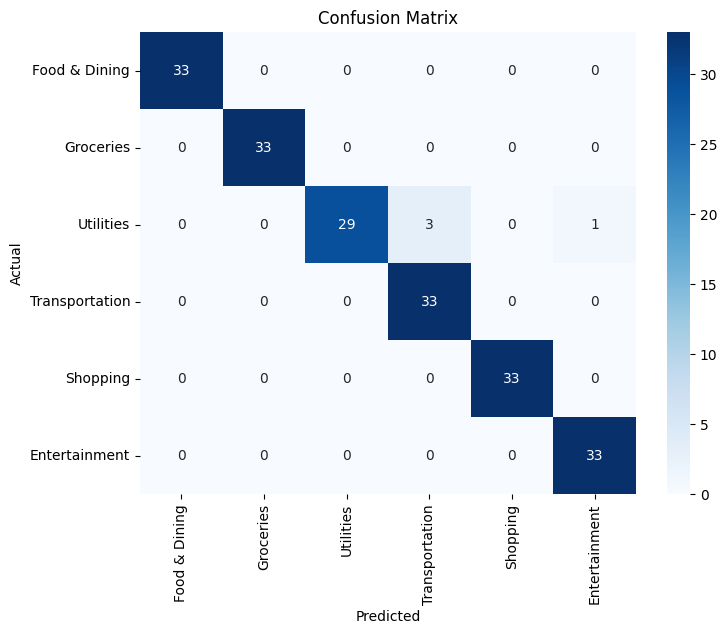

In [33]:
# @title Step 5: Execute Training & Evaluation
system = IntelligentFinancialSystem()
print("Generating Synthetic Data...")
train_df = generate_robust_indian_data(n_samples=800)
test_df = generate_robust_indian_data(n_samples=200)
system.train_graph_context(train_df)
evaluate_model(system, test_df)

In [34]:
# @title Step 5.1: Measure Batch Inference Performance
import time

def measure_batch_performance(system, test_df):
    print(f"Benchmarking System on {len(test_df)} transactions...")

    transactions = test_df['transaction'].tolist()

    # 1. Start Timer
    start_time = time.time()

    # 2. Run Batch Inference
    _ = [system.predict(txt) for txt in transactions]

    # 3. Stop Timer
    end_time = time.time()

    total_time = end_time - start_time
    num_samples = len(transactions)

    avg_latency_ms = (total_time / num_samples) * 1000
    throughput_tps = num_samples / total_time

    print("\n" + "="*40)
    print("⚡ PERFORMANCE METRICS REPORT")
    print("="*40)
    print(f"• Batch Size:      {num_samples} records")
    print(f"• Total Time:      {total_time:.4f} seconds")
    print(f"• Avg Latency:     {avg_latency_ms:.2f} ms/transaction")
    print(f"• Throughput:      {throughput_tps:.2f} transactions/sec")
    print("="*40)

measure_batch_performance(system, test_df)

Benchmarking System on 198 transactions...

⚡ PERFORMANCE METRICS REPORT
• Batch Size:      198 records
• Total Time:      0.1161 seconds
• Avg Latency:     0.59 ms/transaction
• Throughput:      1705.60 transactions/sec


In [35]:
# @title Step 6: Interactive Dashboard (Conditional Feedback)

output_feedback = widgets.Output()

cat_name_input = widgets.Text(description='New Cat:')
cat_desc_input = widgets.Text(description='Desc:')
add_cat_btn = widgets.Button(description='Add Category', button_style='success')

def on_add_cat(b):
    with output_feedback:
        msg = system.add_new_category(cat_name_input.value, cat_desc_input.value)
        print(msg)
        feedback_dropdown.options = system.category_names
add_cat_btn.on_click(on_add_cat)


txn_input = widgets.Text(description='Txn Text:', placeholder='e.g. UPI/SWIGGY...')
feedback_dropdown = widgets.Dropdown(options=system.category_names, description='Correct Cat:')
predict_btn = widgets.Button(description='Predict', button_style='info')
correct_btn = widgets.Button(description='Submit Feedback', button_style='warning')

feedback_box = widgets.HBox([feedback_dropdown, correct_btn])
feedback_box.layout.display = 'none'

def on_predict(b):
    with output_feedback:
        clear_output()
        feedback_box.layout.display = 'none'

        res = system.predict(txn_input.value)
        conf = res['confidence']

        display(HTML(f"<h4>Prediction: {res['category']}</h4>"))
        display(HTML(f"<p>Conf: <b>{conf:.2f}</b> | Method: {res['method']}</p>"))

        if conf < 0.55:
            display(HTML(f"<p style='color:red'>Low Confidence. Please correct below:</p>"))
            feedback_dropdown.value = res['category']
            feedback_box.layout.display = 'flex'
            display(feedback_box)
def on_correct(b):
    with output_feedback:
        msg = system.active_learning_update(txn_input.value, feedback_dropdown.value)
        print(msg)
        feedback_box.layout.display = 'none'

predict_btn.on_click(on_predict)
correct_btn.on_click(on_correct)

display(HTML("<h3>1. Admin: Category Management</h3>"))
display(widgets.HBox([cat_name_input, cat_desc_input, add_cat_btn]))
display(HTML("<hr><h3>2. User: Predict & Train</h3>"))
display(widgets.HBox([txn_input, predict_btn]))
display(output_feedback)

Output()